In [2]:
import numpy as np
import numpy.random as rn
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pgds import PGDS

In [3]:
data_dict = np.load('../dat/icews/undirected/2003-D/data.npz')

In [4]:
Y_TV = data_dict['Y_TV']          # observed TxV count matrix
(T, V) = Y_TV.shape
print 'T = %d time steps' % T
print 'V = %d features' % V

T = 365 time steps
V = 6197 features


In [5]:
dates_T = data_dict['dates_T']    # time steps are days in 2003
print 'First time step: %s' % dates_T[0]
print 'Last time step: %s' % dates_T[-1]

First time step: 2003-01-01T00:00:00.000000000
Last time step: 2003-12-31T00:00:00.000000000


In [6]:
labels_V = data_dict['labels_V']  # features are undirected edges of countries 
print 'Most active feature: %s' % labels_V[0]
print 'Least active feature: %s' % labels_V[-1]

Most active feature: Iraq--United States
Least active feature: Brazil--Uganda


# Exploratory analysis

In [6]:
K = 100            # number of latent components
gam = 75           # shrinkage parameter
tau = 1            # concentration parameter
eps = 0.1          # uninformative gamma parameter
stationary = True  # stationary variant of the model
steady = True      # use steady state approx. (only for stationary)
shrink = True      # use the shrinkage version
binary = False     # whether the data is binary (vs. counts)
seed = 11111       # random seed (optional)

model = PGDS(T=T, V=V, K=K, eps=eps, gam=gam, tau=tau,
             stationary=int(stationary), steady=int(steady),
             shrink=int(shrink), binary=int(binary), seed=seed)

In [76]:
num_itns = 1000    # number of Gibbs sampling iterations (the more the merrier)
verbose = True     # whether to print out state
initialize = True  # whether to initialize model randomly

model.fit(data=Y_TV,
          num_itns=num_itns,
          verbose=verbose,
          initialize=initialize)

193.7511ms: sampling Y_KV
0.0010ms: sampling Y_TK
53.8189ms: sampling L_TKK
0.0072ms: sampling delta_T
90.6751ms: sampling Phi_KV
6.5739ms: sampling Theta_TK
1.0350ms: sampling Pi_KK
0.0019ms: sampling beta
0.9661ms: sampling H_KK
0.0010ms: sampling lnq_K
0.2041ms: sampling nu_K
0.0012ms: sampling xi_K
ITERATION 110: total aux counts: 74677	                mean theta: 0.8478	 mean delta: 14.822817

182.9309ms: sampling Y_KV
0.0019ms: sampling Y_TK
40.0400ms: sampling L_TKK
0.0129ms: sampling delta_T
91.2669ms: sampling Phi_KV
7.9620ms: sampling Theta_TK
1.1871ms: sampling Pi_KK
0.0010ms: sampling beta
0.8318ms: sampling H_KK
0.0010ms: sampling lnq_K
0.2091ms: sampling nu_K
0.0010ms: sampling xi_K
ITERATION 120: total aux counts: 61393	                mean theta: 0.6197	 mean delta: 20.560486

179.8730ms: sampling Y_KV
0.0031ms: sampling Y_TK
30.3710ms: sampling L_TKK
0.0050ms: sampling delta_T
91.6190ms: sampling Phi_KV
8.6601ms: sampling Theta_TK
1.3070ms: sampling Pi_KK
0.0019ms: sam

In [77]:
state = dict(model.get_state())
Theta_TK = state['Theta_TK']  # TxK time step factors
Phi_KV = state['Phi_KV']      # KxV feature factors
Pi_KK = state['Pi_KK']        # KxK transition matrix
nu_K = state['nu_K']          # K component weights

In [78]:
top_k = nu_K.argmax()                          # most active component
features = Phi_KV[top_k].argsort()[::-1][:10]  # top 10 features in top k
print labels_V[features]

['Iraq--United States' 'Israel--Occupied Palestinian Territory'
 'Russian Federation--United States' 'North Korea--United States'
 'United Kingdom--United States' 'South Korea--United States'
 'Turkey--United States' 'France--United States' 'China--United States'
 'India--Pakistan']


<IPython.core.display.Javascript object>


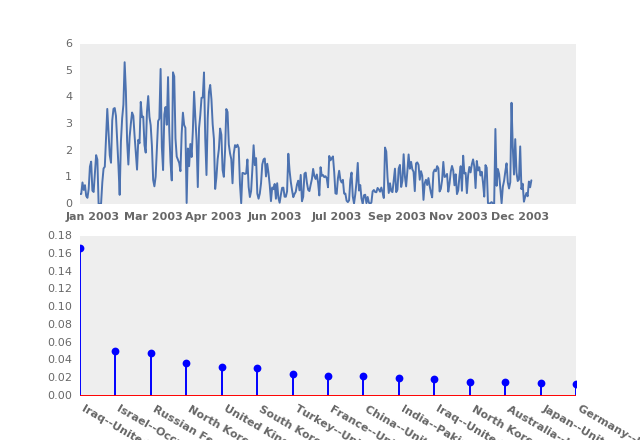

In [80]:
k = top_k # which component to visualize  (replace with any k = 1...K to further explore)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Plot time-step factors for component k
ax1.plot(Theta_TK[:, k])
xticks = np.linspace(10, Theta_TK.shape[0] - 10, num=8, dtype=int)
ax1.set_xticks(xticks)
ax1.set_xticklabels(formatted_dates[xticks], weight='bold')

# Plot top N feature factors for component k
N = 15
top_N_features = Phi_KV[k].argsort()[::-1][:N]
ax2.stem(Phi_KV[k, top_N_features])
ax2.set_xticks(range(N))
ax2.set_xticklabels(labels_V[top_N_features], rotation=330, weight='bold', ha='left')

plt.show()

In [81]:
# Pro tip: To find interpret the components, Google the top date and top feature(s).

k = top_k                        # which component to explore

top_t = Theta_TK[:, k].argmax()  # top time-step factor
top_date = dates_T[top_t]        # date of top time-step factor (top date)
formatted_date = pd.Timestamp(top_date).strftime('%B %d %Y')
print 'Top date: %s' % formatted_date

N = 3
top_vs = Phi_KV[k, :].argsort()[::-1][:N]   # top N features
top_features = labels_V[top_vs]
print 'Top N features: %s' % top_features

query = formatted_date + ' ' + top_features[0].replace('--', ' ')
print "Example Google query: '%s'" % query


Top date: February 06 2003
Top N features: ['Iraq--United States' 'Israel--Occupied Palestinian Territory'
 'Russian Federation--United States']
Example Google query: 'February 06 2003 Iraq United States'


# Predictive analysis

In [7]:
from run_pgds import mre, mae

In [16]:
S = 2  # how many final time-steps to hold out completely (for forecasting)

data_SV = Y_TV[-S:]    # hold out final S time steps (to forecast)
train_TV = Y_TV[:-S]   # training data matrix is everything up to t=S
(T, V) = train_TV.shape 

percent = 0.1  # percent of training data to mask (for smoothing)
mask_TV = (rn.random(size=(T, V)) < percent).astype(bool)  # create a TxV random mask 

masked_train_TV = np.ma.array(train_TV, mask=mask_TV)

In [17]:
K = 100            # number of latent components
gam = 75           # shrinkage parameter
tau = 1            # concentration parameter
eps = 0.1          # uninformative gamma parameter
stationary = True  # stationary variant of the model
steady = True      # use steady state approx. (only for stationary)
shrink = True      # use the shrinkage version
binary = False     # whether the data is binary (vs. counts)
seed = 11111       # random seed (optional)

model = PGDS(T=T, V=V, K=K, eps=eps, gam=gam, tau=tau,
             stationary=int(stationary), steady=int(steady),
             shrink=int(shrink), binary=int(binary), seed=seed)

In [18]:
num_itns = 100     # number of Gibbs sampling iterations (the more the merrier)
verbose = True     # whether to print out state
initialize = True  # whether to initialize model randomly

model.fit(data=masked_train_TV,
          num_itns=num_itns,
          verbose=verbose,
          initialize=initialize)

644.3059ms: sampling Y_KV
0.0010ms: sampling Y_TK
64.0728ms: sampling L_TKK
0.0062ms: sampling delta_T
85.5980ms: sampling Phi_KV
5.7490ms: sampling Theta_TK
0.9890ms: sampling Pi_KK
0.0010ms: sampling beta
1.1420ms: sampling H_KK
0.0010ms: sampling lnq_K
0.2110ms: sampling nu_K
0.0019ms: sampling xi_K
ITERATION 10: total aux counts: 102347	                mean theta: 0.9583	 mean delta: 19.859592

632.5729ms: sampling Y_KV
0.0019ms: sampling Y_TK
69.2461ms: sampling L_TKK
0.0169ms: sampling delta_T
98.0361ms: sampling Phi_KV
6.3472ms: sampling Theta_TK
1.0321ms: sampling Pi_KK
0.0019ms: sampling beta
1.0591ms: sampling H_KK
0.0010ms: sampling lnq_K
0.2210ms: sampling nu_K
0.0021ms: sampling xi_K
ITERATION 20: total aux counts: 87160	                mean theta: 0.8219	 mean delta: 23.116496

630.8830ms: sampling Y_KV
0.0021ms: sampling Y_TK
51.6112ms: sampling L_TKK
0.0141ms: sampling delta_T
85.6750ms: sampling Phi_KV
6.8128ms: sampling Theta_TK
1.0998ms: sampling Pi_KK
0.0019ms: samp

In [21]:
pred_TV = model.reconstruct()  # reconstruction of the training matrix

train_mae = mae(train_TV[~mask_TV], pred_TV[~mask_TV])
train_mre = mre(train_TV[~mask_TV], pred_TV[~mask_TV])

smooth_mae = mae(train_TV[mask_TV], pred_TV[mask_TV])
smooth_mre = mre(train_TV[mask_TV], pred_TV[mask_TV])

print 'Mean absolute error on reconstructing observed data: %f' % train_mae
print 'Mean relative error on reconstructing observed data: %f' % train_mre
print 'Mean absolute error on smoothing missing data: %f' % smooth_mae
print 'Mean relative error on smoothing missing data: %f' % smooth_mre

Mean absolute error on reconstructing observed data: 0.274113
Mean relative error on reconstructing observed data: 0.184268
Mean absolute error on smoothing missing data: 0.428991
Mean relative error on smoothing missing data: 0.307468


In [22]:
pred_SV = model.forecast(n_timesteps=S)  # forecast of next S time steps

forecast_mae = mae(data_SV, pred_SV)
forecast_mre = mre(data_SV, pred_SV)

print 'Mean absolute error on forecasting: %f' % forecast_mae
print 'Mean relative error on forecasting: %f' % forecast_mre

Mean absolute error on forecasting: 0.290658
Mean relative error on forecasting: 0.214830


In [23]:
initialize = False  # run some more iterations---i.e., don't reinitialize

model.fit(data=masked_train_TV,
          num_itns=num_itns,
          verbose=verbose,
          initialize=initialize)

887.8720ms: sampling Y_KV
0.0019ms: sampling Y_TK
34.6799ms: sampling L_TKK
0.0060ms: sampling delta_T
85.5451ms: sampling Phi_KV
8.2090ms: sampling Theta_TK
1.2999ms: sampling Pi_KK
0.0019ms: sampling beta
0.7980ms: sampling H_KK
0.0010ms: sampling lnq_K
0.2182ms: sampling nu_K
0.0012ms: sampling xi_K
ITERATION 110: total aux counts: 65562	                mean theta: 0.4921	 mean delta: 39.828081

621.9270ms: sampling Y_KV
0.0041ms: sampling Y_TK
33.9901ms: sampling L_TKK
0.0060ms: sampling delta_T
85.3031ms: sampling Phi_KV
8.2200ms: sampling Theta_TK
1.3120ms: sampling Pi_KK
0.0010ms: sampling beta
0.8070ms: sampling H_KK
0.0010ms: sampling lnq_K
0.2351ms: sampling nu_K
0.0010ms: sampling xi_K
ITERATION 120: total aux counts: 64100	                mean theta: 0.4755	 mean delta: 41.289397

618.5899ms: sampling Y_KV
0.0010ms: sampling Y_TK
33.0169ms: sampling L_TKK
0.0060ms: sampling delta_T
85.3388ms: sampling Phi_KV
8.2340ms: sampling Theta_TK
1.3051ms: sampling Pi_KK
0.0010ms: sam

In [24]:
new_pred_TV = model.reconstruct()  # reconstruction of the training matrix from new sample
avg_pred_TV = (pred_TV + new_pred_TV) / 2.  # compute avg. reconstruction

train_mae = mae(train_TV[~mask_TV], avg_pred_TV[~mask_TV])
train_mre = mre(train_TV[~mask_TV], avg_pred_TV[~mask_TV])

smooth_mae = mae(train_TV[mask_TV], avg_pred_TV[mask_TV])
smooth_mre = mre(train_TV[mask_TV], avg_pred_TV[mask_TV])

print 'Mean absolute error on reconstructing observed data: %f' % train_mae
print 'Mean relative error on reconstructing observed data: %f' % train_mre
print 'Mean absolute error on smoothing missing data: %f' % smooth_mae
print 'Mean relative error on smoothing missing data: %f' % smooth_mre

Mean absolute error on reconstructing observed data: 0.267592
Mean relative error on reconstructing observed data: 0.181568
Mean absolute error on smoothing missing data: 0.435712
Mean relative error on smoothing missing data: 0.314355


In [25]:
new_pred_SV = model.forecast(n_timesteps=S)  # forecast of next S time steps from new sample
avg_pred_SV = (pred_SV + new_pred_SV) / 2.   # compute avg. forecast

forecast_mae = mae(data_SV, avg_pred_SV) 
forecast_mre = mre(data_SV, avg_pred_SV)

print 'Mean absolute error on forecasting: %f' % forecast_mae
print 'Mean relative error on forecasting: %f' % forecast_mre

Mean absolute error on forecasting: 0.285061
Mean relative error on forecasting: 0.209245
